In [1]:
import pandas as pd
import numpy as np
import soundfile
import os
import sys
import glob

In [2]:
import librosa
import librosa.display
import seaborn as sbn
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [7]:
Crema = "Crema\\AudioWAV\\"

In [8]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,Crema\AudioWAV\1001_DFA_ANG_XX.wav
1,disgust,Crema\AudioWAV\1001_DFA_DIS_XX.wav
2,fear,Crema\AudioWAV\1001_DFA_FEA_XX.wav
3,happy,Crema\AudioWAV\1001_DFA_HAP_XX.wav
4,neutral,Crema\AudioWAV\1001_DFA_NEU_XX.wav


In [9]:
Tess = "TESS\\TESS Toronto emotional speech set data\\"

tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

# for dir in tess_directory_list:
#     directories = os.listdir(Tess + dir)
for actor_dir in tess_directory_list:
    actor_path = os.path.join(Tess, actor_dir)

    # Check if it's a directory before listing its contents
    if os.path.isdir(actor_path):
        directories = os.listdir(actor_path)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + actor_dir+ "/"  + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,angry,TESS\TESS Toronto emotional speech set data\OA...
1,angry,TESS\TESS Toronto emotional speech set data\OA...
2,angry,TESS\TESS Toronto emotional speech set data\OA...
3,angry,TESS\TESS Toronto emotional speech set data\OA...
4,angry,TESS\TESS Toronto emotional speech set data\OA...


In [10]:
tess_directory_list = os.listdir(Tess)

In [11]:
data_path = pd.concat([Crema_df,Tess_df],axis=0)
data_path.to_csv( "ravdess.csv", index = False)
data_path.head()

,Emotions,Path
0,angry,Crema\AudioWAV\1001_DFA_ANG_XX.wav
1,disgust,Crema\AudioWAV\1001_DFA_DIS_XX.wav
2,fear,Crema\AudioWAV\1001_DFA_FEA_XX.wav
3,happy,Crema\AudioWAV\1001_DFA_HAP_XX.wav
4,neutral,Crema\AudioWAV\1001_DFA_NEU_XX.wav


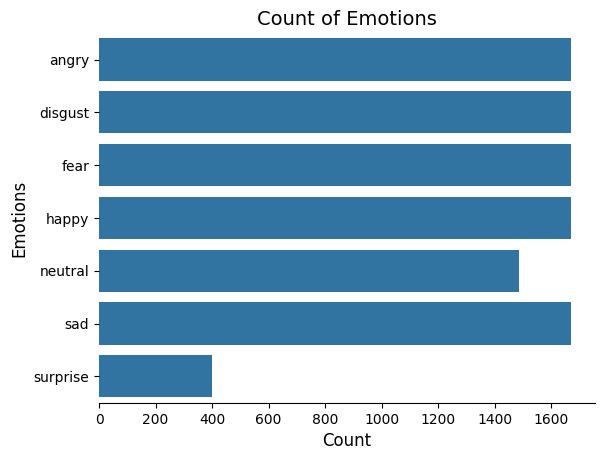

In [12]:
plt.title('Count of Emotions',size=14)
sbn.countplot(data_path.Emotions)
plt.ylabel('Emotions',size=12)
plt.xlabel('Count',size = 12)
sbn.despine(top=True,right=True,left=True,bottom=False)
plt.show()

In [13]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(np.arange(len(data)) / float(sr), data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()



In [14]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

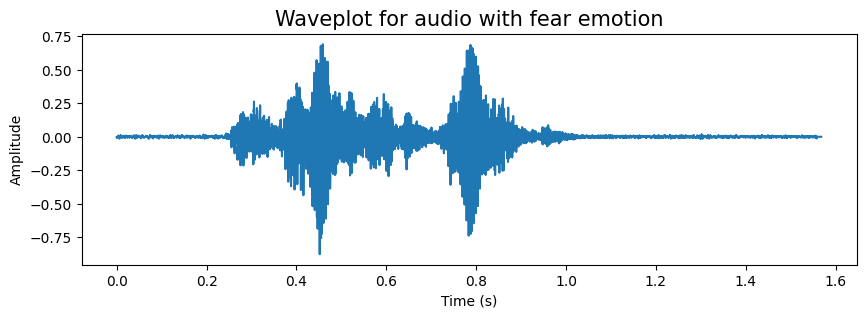

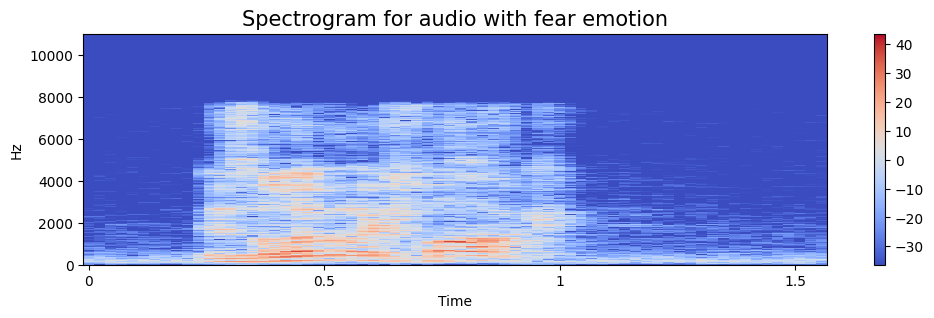

In [15]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [16]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data,sr=sampling_rate,n_steps=pitch_factor)


path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path,duration=2, offset=0.6, sr=8025)

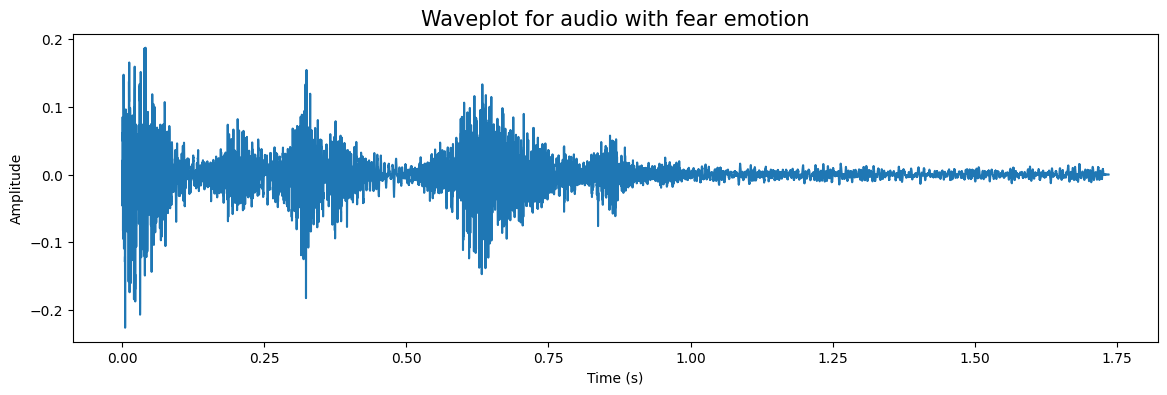

In [18]:
x = noise(data)
plt.figure(figsize=(14,4))
plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
plt.plot(np.arange(len(data)) / float(sample_rate), data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

Audio(path)

In [20]:
emotions = {
    '01':'neutral',
    '02':'happy',
    '03':'sad',
    '04':'angry',
    '05':'fearful',
    '06':'disgust',
    '07':'surprised'
}


In [21]:
cent = librosa.feature.spectral_centroid(y=data, sr=sample_rate)
cent

array([[1166.58363074, 1086.16841592, 1043.04213362, 1087.06454682,
        1125.33088396, 1129.92437523, 1079.40298108, 1038.31790991,
        1750.0014184 , 1536.67646252, 1374.64979816, 1416.51008526,
        1522.33712032, 1444.56506443, 1394.7422506 , 1257.85601843,
        1003.43280041,  657.1245475 ,  718.37659414,  632.87007203,
         589.43715204,  581.88325273,  592.91655062,  620.18815561,
         609.78103478,  609.15352579,  573.60547913,  542.70663727]])

In [57]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    #spectral centroid
    # spec_centroid = np.mean(librosa.feature.spectral_centroid(y=data,sr = sample_rate).T,axis=0)
    # result = np.hstack((result,spec_centroid))
    
    #spectral bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data,sr=sample_rate).T ,axis=0)
    result = np.hstack((result,spectral_bandwidth))
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
       
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    
    return result

In [59]:
X, Y = [], []

for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    



c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [60]:
data_path.Path.shape

(10242,)

In [ ]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features_to_full.csv', index=False)
# Features.head()


In [3]:
df = pd.read_csv('features_of_full.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.054342,0.376664,0.466581,0.666377,0.503269,0.450576,0.540493,0.509086,0.578561,0.526342,...,0.000303,0.000436,0.000365,0.000219,0.000132,0.000098,0.000101,0.000049,1.167064e-06,angry
1,0.205638,0.490481,0.540013,0.709411,0.571842,0.545824,0.593973,0.645565,0.744487,0.664384,...,0.003297,0.003809,0.004207,0.003849,0.003862,0.003307,0.003174,0.003546,3.320770e-03,angry
2,0.073797,0.432647,0.311726,0.565696,0.656160,0.438362,0.504386,0.565138,0.528582,0.578393,...,0.000073,0.000136,0.000093,0.000126,0.000080,0.000057,0.000021,0.000003,1.502761e-07,angry
3,0.058006,0.501620,0.391186,0.442036,0.417065,0.375968,0.404933,0.479065,0.656705,0.479064,...,0.000027,0.000032,0.000039,0.000060,0.000057,0.000049,0.000053,0.000007,2.236825e-07,angry
4,0.149747,0.415048,0.468484,0.493526,0.439315,0.472464,0.540090,0.758423,0.673488,0.561516,...,0.000437,0.000396,0.000488,0.000505,0.000459,0.000489,0.000559,0.000453,3.948016e-04,angry


In [4]:
X,Y=[],[]
X = df.iloc[:, :-1].values


In [5]:
Y = df['labels'].values

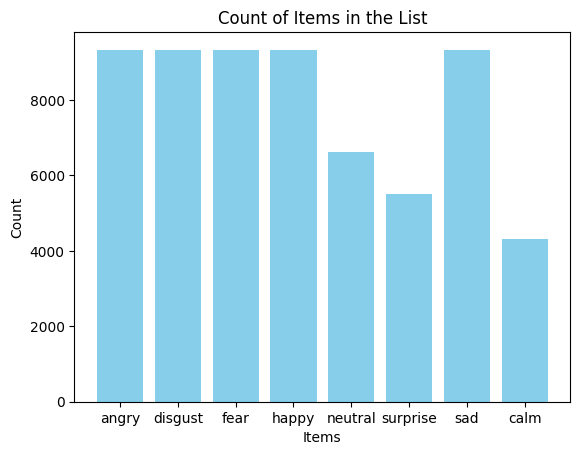

In [6]:
import matplotlib.pyplot as plt
from collections import Counter


item_counts = Counter(Y)

# Extract items and their corresponding counts
items = list(item_counts.keys())
counts = list(item_counts.values())

# Plot the bar graph
plt.bar(items, counts, color='skyblue')
plt.xlabel('Items')
plt.ylabel('Count')
plt.title('Count of Items in the List')
plt.show()


In [16]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((47344, 162), (47344, 8), (15782, 162), (15782, 8))

In [18]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

# Transform the test data using the fitted scaler
x_test = scaler.transform(x_test)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((47344, 162), (47344, 8), (15782, 162), (15782, 8))

In [20]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (47344, 162)
y_train shape: (47344, 8)


In [25]:
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 162, 64)           384       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 81, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 81, 128)           41088     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 41, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 41, 256)           164096    
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 21, 256)          

In [28]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


740/740 [==============================] - 47s 61ms/step - loss: 1.6737 - accuracy: 0.3226 - val_loss: 1.1959 - val_accuracy: 0.5504 - lr: 0.0010
Epoch 2/50
740/740 [==============================] - 52s 70ms/step - loss: 1.0708 - accuracy: 0.5821 - val_loss: 0.7517 - val_accuracy: 0.7101 - lr: 0.0010
Epoch 3/50
740/740 [==============================] - 52s 70ms/step - loss: 0.7894 - accuracy: 0.6973 - val_loss: 0.6465 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 4/50
740/740 [==============================] - 52s 70ms/step - loss: 0.6858 - accuracy: 0.7349 - val_loss: 0.6018 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 5/50
740/740 [==============================] - 51s 69ms/step - loss: 0.6479 - accuracy: 0.7460 - val_loss: 0.5858 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 6/50
740/740 [==============================] - 52s 70ms/step - loss: 0.6212 - accuracy: 0.7537 - val_loss: 0.5593 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 7/50
740/740 [==============================] - 51

494/494 [==============================] - 7s 14ms/step - loss: 0.6041 - accuracy: 0.8156
Accuracy of our model on test data :  81.56127333641052 %


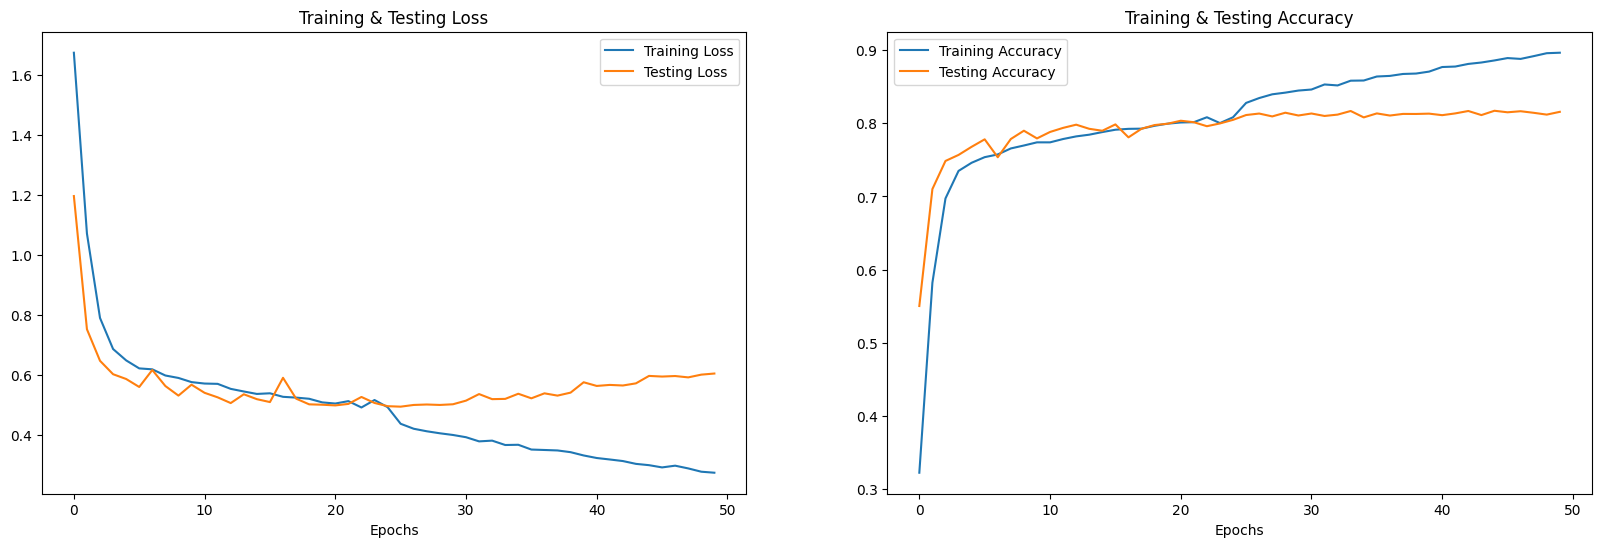

In [29]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [30]:

# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

494/494 [==============================] - 7s 13ms/step


In [31]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,happy,angry
2,sad,neutral
3,disgust,disgust
4,neutral,neutral
5,sad,neutral
6,neutral,neutral
7,disgust,disgust
8,calm,calm
9,happy,happy


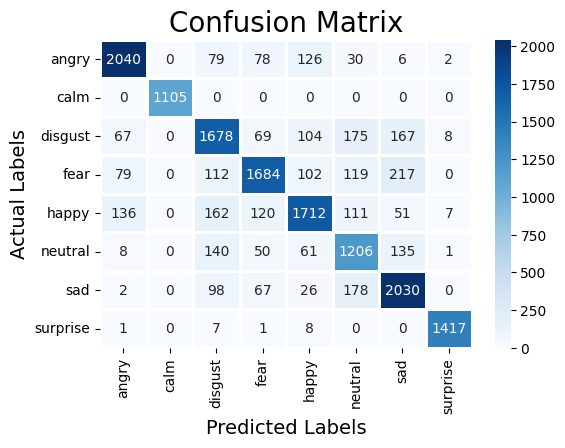

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6,4))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sbn.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.87      0.86      0.87      2361
        calm       1.00      1.00      1.00      1105
     disgust       0.74      0.74      0.74      2268
        fear       0.81      0.73      0.77      2313
       happy       0.80      0.74      0.77      2299
     neutral       0.66      0.75      0.71      1601
         sad       0.78      0.85      0.81      2401
    surprise       0.99      0.99      0.99      1434

    accuracy                           0.82     15782
   macro avg       0.83      0.83      0.83     15782
weighted avg       0.82      0.82      0.82     15782



In [78]:
model.save_weights("model_on_5th_jan.h5")
model_json = model.to_json()
with open("model_a_on_5th_jan.json","w") as json_file:
    json_file.write(model_json)